# Causal program-aided language (CPAL) chain

The CPAL chain builds on the recent PAL to stop LLM hallucination. The problem with the PAL approach is that it hallucinates on a math problem with a nested chain of dependence. The innovation here is that this new CPAL approach includes causal structure to fix hallucination.

The original [PR's description](https://github.com/hwchase17/langchain/pull/6255) contains a full overview.

Using the CPAL chain, the LLM translated this

    "Tim buys the same number of pets as Cindy and Boris."
    "Cindy buys the same number of pets as Bill plus Bob."
    "Boris buys the same number of pets as Ben plus Beth."
    "Bill buys the same number of pets as Obama."
    "Bob buys the same number of pets as Obama."
    "Ben buys the same number of pets as Obama."
    "Beth buys the same number of pets as Obama."
    "If Obama buys one pet, how many pets total does everyone buy?"


into this

![complex-graph.png](/img/cpal_diagram.png).

Outline of code examples demoed in this notebook.

1. CPAL's value against hallucination: CPAL vs PAL  
    1.1 Complex narrative  
    1.2 Unanswerable math word problem  
2. CPAL's three types of causal diagrams ([The Book of Why](https://en.wikipedia.org/wiki/The_Book_of_Why)).   
    2.1 Mediator   
    2.2 Collider   
    2.3 Confounder   

In [1]:
from IPython.display import SVG

from langchain.experimental.cpal.base import CPALChain
from langchain.chains import PALChain
from langchain import OpenAI

llm = OpenAI(temperature=0, max_tokens=512)
cpal_chain = CPALChain.from_univariate_prompt(llm=llm, verbose=True)
pal_chain = PALChain.from_math_prompt(llm=llm, verbose=True)

## CPAL's value against hallucination: CPAL vs PAL

Like PAL, CPAL intends to reduce large language model (LLM) hallucination.

The CPAL chain is different from the PAL chain for a couple of reasons.

CPAL adds a causal structure (or DAG) to link entity actions (or math expressions).
The CPAL math expressions are modeling a chain of cause and effect relations, which can be intervened upon, whereas for the PAL chain math expressions are projected math identities.


### 1.1 Complex narrative

Takeaway: PAL hallucinates, CPAL does not hallucinate.

In [2]:
question = (
    "Tim buys the same number of pets as Cindy and Boris."
    "Cindy buys the same number of pets as Bill plus Bob."
    "Boris buys the same number of pets as Ben plus Beth."
    "Bill buys the same number of pets as Obama."
    "Bob buys the same number of pets as Obama."
    "Ben buys the same number of pets as Obama."
    "Beth buys the same number of pets as Obama."
    "If Obama buys one pet, how many pets total does everyone buy?"
)

In [3]:
pal_chain.run(question)



> Entering new  chain...
def solution():
    """Tim buys the same number of pets as Cindy and Boris.Cindy buys the same number of pets as Bill plus Bob.Boris buys the same number of pets as Ben plus Beth.Bill buys the same number of pets as Obama.Bob buys the same number of pets as Obama.Ben buys the same number of pets as Obama.Beth buys the same number of pets as Obama.If Obama buys one pet, how many pets total does everyone buy?"""
    obama_pets = 1
    tim_pets = obama_pets
    cindy_pets = obama_pets + obama_pets
    boris_pets = obama_pets + obama_pets
    total_pets = tim_pets + cindy_pets + boris_pets
    result = total_pets
    return result

> Finished chain.


'5'

In [4]:
cpal_chain.run(question)



> Entering new  chain...
story outcome data
    name                                   code  value      depends_on
0  obama                                   pass    1.0              []
1   bill               bill.value = obama.value    1.0         [obama]
2    bob                bob.value = obama.value    1.0         [obama]
3    ben                ben.value = obama.value    1.0         [obama]
4   beth               beth.value = obama.value    1.0         [obama]
5  cindy   cindy.value = bill.value + bob.value    2.0     [bill, bob]
6  boris   boris.value = ben.value + beth.value    2.0     [ben, beth]
7    tim  tim.value = cindy.value + boris.value    4.0  [cindy, boris]

query data
{
    "question": "how many pets total does everyone buy?",
    "expression": "SELECT SUM(value) FROM df",
    "llm_error_msg": ""
}


> Finished chain.


13.0

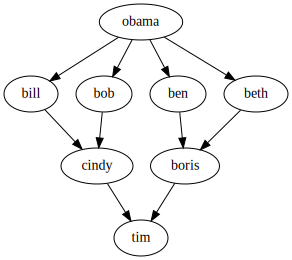

In [5]:
# wait 20 secs to see display
cpal_chain.draw(path="web.svg")
SVG("web.svg")

### Unanswerable math

Takeaway: PAL hallucinates, where CPAL, rather than hallucinate, answers with _"unanswerable, narrative question and plot are incoherent"_

In [6]:
question = (
    "Jan has three times the number of pets as Marcia."
    "Marcia has two more pets than Cindy."
    "If Cindy has ten pets, how many pets does Barak have?"
)

In [7]:
pal_chain.run(question)



> Entering new  chain...
def solution():
    """Jan has three times the number of pets as Marcia.Marcia has two more pets than Cindy.If Cindy has ten pets, how many pets does Barak have?"""
    cindy_pets = 10
    marcia_pets = cindy_pets + 2
    jan_pets = marcia_pets * 3
    result = jan_pets
    return result

> Finished chain.


'36'

In [8]:
try:
    cpal_chain.run(question)
except Exception as e_msg:
    print(e_msg)



> Entering new  chain...
story outcome data
     name                            code  value depends_on
0   cindy                            pass   10.0         []
1  marcia  marcia.value = cindy.value + 2   12.0    [cindy]
2     jan    jan.value = marcia.value * 3   36.0   [marcia]

query data
{
    "question": "how many pets does barak have?",
    "expression": "SELECT name, value FROM df WHERE name = 'barak'",
    "llm_error_msg": ""
}

unanswerable, query and outcome are incoherent

outcome:
     name                            code  value depends_on
0   cindy                            pass   10.0         []
1  marcia  marcia.value = cindy.value + 2   12.0    [cindy]
2     jan    jan.value = marcia.value * 3   36.0   [marcia]
query:
{'question': 'how many pets does barak have?', 'expression': "SELECT name, value FROM df WHERE name = 'barak'", 'llm_error_msg': ''}


### Basic math

#### Causal mediator

In [9]:
question = (
    "Jan has three times the number of pets as Marcia. "
    "Marcia has two more pets than Cindy. "
    "If Cindy has four pets, how many total pets do the three have?"
)

---
PAL

In [10]:
pal_chain.run(question)



> Entering new  chain...
def solution():
    """Jan has three times the number of pets as Marcia. Marcia has two more pets than Cindy. If Cindy has four pets, how many total pets do the three have?"""
    cindy_pets = 4
    marcia_pets = cindy_pets + 2
    jan_pets = marcia_pets * 3
    total_pets = cindy_pets + marcia_pets + jan_pets
    result = total_pets
    return result

> Finished chain.


'28'

---
CPAL

In [11]:
cpal_chain.run(question)



> Entering new  chain...
story outcome data
     name                            code  value depends_on
0   cindy                            pass    4.0         []
1  marcia  marcia.value = cindy.value + 2    6.0    [cindy]
2     jan    jan.value = marcia.value * 3   18.0   [marcia]

query data
{
    "question": "how many total pets do the three have?",
    "expression": "SELECT SUM(value) FROM df",
    "llm_error_msg": ""
}


> Finished chain.


28.0

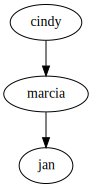

In [12]:
# wait 20 secs to see display
cpal_chain.draw(path="web.svg")
SVG("web.svg")

### Causal collider

In [13]:
question = (
    "Jan has the number of pets as Marcia plus the number of pets as Cindy. "
    "Marcia has no pets. "
    "If Cindy has four pets, how many total pets do the three have?"
)

In [14]:
cpal_chain.run(question)



> Entering new  chain...
story outcome data
     name                                    code  value       depends_on
0  marcia                                    pass    0.0               []
1   cindy                                    pass    4.0               []
2     jan  jan.value = marcia.value + cindy.value    4.0  [marcia, cindy]

query data
{
    "question": "how many total pets do the three have?",
    "expression": "SELECT SUM(value) FROM df",
    "llm_error_msg": ""
}


> Finished chain.


8.0

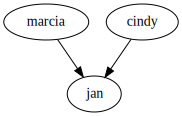

In [15]:
# wait 20 secs to see display
cpal_chain.draw(path="web.svg")
SVG("web.svg")

### Causal confounder

In [16]:
question = (
    "Jan has the number of pets as Marcia plus the number of pets as Cindy. "
    "Marcia has two more pets than Cindy. "
    "If Cindy has four pets, how many total pets do the three have?"
)

In [17]:
cpal_chain.run(question)



> Entering new  chain...
story outcome data
     name                                    code  value       depends_on
0   cindy                                    pass    4.0               []
1  marcia          marcia.value = cindy.value + 2    6.0          [cindy]
2     jan  jan.value = cindy.value + marcia.value   10.0  [cindy, marcia]

query data
{
    "question": "how many total pets do the three have?",
    "expression": "SELECT SUM(value) FROM df",
    "llm_error_msg": ""
}


> Finished chain.


20.0

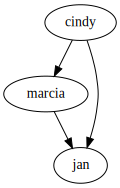

In [18]:
# wait 20 secs to see display
cpal_chain.draw(path="web.svg")
SVG("web.svg")

In [19]:
%load_ext autoreload
%autoreload 2